<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://www.univ-tlse3.fr/" ><img src="http://www.univ-tlse3.fr/medias/photo/ut3pres_logoq_1372757033342.jpg?ID_FICHE=49702" style="float:right; max-width: 250px; display: inline" alt="INSA"/></a> 
</center>

# Correction par transport optimal

In this notebook we run the correction algorithm developed by Jean-Michel Loubes and based on the optimal transport theory. We use the dataset $\textit{AdultCensus}$.

In [1]:
install.packages("lpSolve", repos= "https://cran.r-project.org")
install.packages("clue", repos= "https://cran.r-project.org")
install.packages("ranger",repos="https://cran.r-project.org")

Installing package into 'C:/Users/fanny/OneDrive/Documents/R/win-library/3.4'
(as 'lib' is unspecified)


package 'lpSolve' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\fanny\AppData\Local\Temp\Rtmpcb215y\downloaded_packages


Installing package into 'C:/Users/fanny/OneDrive/Documents/R/win-library/3.4'
(as 'lib' is unspecified)


package 'clue' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\fanny\AppData\Local\Temp\Rtmpcb215y\downloaded_packages


Installing package into 'C:/Users/fanny/OneDrive/Documents/R/win-library/3.4'
(as 'lib' is unspecified)


package 'ranger' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\fanny\AppData\Local\Temp\Rtmpcb215y\downloaded_packages


In [2]:
path=""
source(paste(path,"dataPrepAdultCensus.R",sep=""))
adult = dataBase

In [3]:
###CONFIDENCE INTERVAL AND TEST FOR W_P(F,G)
WassCI<-function(x,y,p,delta0){
  n0<-length(x)
  n1<-length(y)
  #wasserstein distance between g(x)|s=0 and g(x)|s=1
  x0_sort<-sort(x)
  x1_sort<-sort(y)
  #edf
  Q0<-ecdf(x)
  Q1<-ecdf(y)
  #p<-2
  
  grid<-unique(sort(c(seq(0,1,by=1/n0), seq(0,1,by=1/n1))))
  #Wp_p<-sum((grid[2:length(grid)]-grid[1:(length(grid)-1)])*((abs(sapply(X=grid, FUN=Q1)-sapply(X=grid,FUN=Q0))^p)[1:(length(grid)-1)]))
  Wp_p<-sum((grid[2:length(grid)]-grid[1:(length(grid)-1)])*((abs(quantile(x,probs=grid)-quantile(y,probs=grid))^p)[1:(length(grid)-1)]))
  
  #Wp_p<-c(Wp_p,(1/(n0+n1))*sum(abs(x0_sort-x1_sort)^p))
 
   #variance estimation
  d1_in<-rep(0,n0-1)
  d2_in<-rep(0,n1-1)
  for(i in 2:n0){
    d1_in[i-1]<- sum(abs(x0_sort[2:i]-quantile(Q1, probs=(1/n0)*c(1:(i-1))))^p - abs(x0_sort[1:(i-1)]-quantile(Q1, probs=(1/n0)*c(1:(i-1))))^p)
  }
  for(i in 2:n1){
  d2_in[i-1]<-sum(abs(x1_sort[2:i]-quantile(Q0,probs=(1/n1)*c(1:(i-1))))^p - abs(x1_sort[1:(i-1)]-quantile(Q0,(1/n1)*c(1:(i-1))))^p)
  }
  sigma1_hat<-mean(d1_in^2)-(mean(d1_in))^2
  sigma2_hat<-mean(d2_in^2)-(mean(d2_in))^2
  sigma_hat<-0.5*sigma1_hat+0.5*sigma2_hat
  sd_hat<-sqrt(0.5*sigma1_hat+0.5*sigma2_hat)
  
  #IC
  alpha<-0.05
  low_lim<-Wp_p-qnorm(1-alpha/2)*(sd_hat/sqrt((n0*n1)/(n0+n1)))
  upp_lim<-Wp_p+qnorm(1-alpha/2)*(sd_hat/sqrt((n0*n1)/(n0+n1)))
 
  
  test<-1*((sqrt(n0*n1/(n0+n1))/sd_hat)*(Wp_p-delta0^p)<qnorm(alpha))
  return( c(low_lim, Wp_p, upp_lim, test))
}

In [4]:
library(lpSolve)
library(clue) ## No usada. Sirve para problema de asignacion con algoritmo hungaro
source("disparate.R")
#load("adultCensus.dat")
n<-nrow(adult)
adult

Warning message:
"package 'lpSolve' was built under R version 3.4.4"Warning message:
"package 'clue' was built under R version 3.4.4"

,age,workClass,fnlwgt,education,educNum,mariStat,occup,relationship,origEthn,sex,capitalGain,capitalLoss,hoursWeek,nativCountry,income,LcapitalGain,LcapitalLoss,ageQ,hoursWeekQ
1,39,Other-Govt,77516,Bachelors,13,Never-Married,Admin,Not-in-family,White,Male,cgLow,None,40,United-States,incLow,7.684784,0.000000,Ag3,HW2
2,50,Self-Employed,83311,Bachelors,13,Married,White-Collar,Husband,White,Male,None,None,13,United-States,incLow,0.000000,0.000000,Ag4,HW1
3,38,Private,215646,HS-grad,9,Not-Married,Blue-Collar,Not-in-family,White,Male,None,None,40,United-States,incLow,0.000000,0.000000,Ag3,HW2
4,53,Private,234721,Dropout,7,Married,Blue-Collar,Husband,Black,Male,None,None,40,United-States,incLow,0.000000,0.000000,Ag5,HW2
5,28,Private,338409,Bachelors,13,Married,Professional,Wife,Black,Female,None,None,40,Other,incLow,0.000000,0.000000,Ag2,HW2
6,37,Private,284582,Masters,14,Married,White-Collar,Wife,White,Female,None,None,40,United-States,incLow,0.000000,0.000000,Ag3,HW2
7,49,Private,160187,Dropout,5,Not-Married,Service,Not-in-family,Black,Female,None,None,16,Latin-America,incLow,0.000000,0.000000,Ag4,HW1
8,52,Self-Employed,209642,HS-grad,9,Married,White-Collar,Husband,White,Male,None,None,45,United-States,incHigh,0.000000,0.000000,Ag5,HW3
9,31,Private,45781,Masters,14,Never-Married,Professional,Not-in-family,White,Female,cgHigh,None,50,United-States,incHigh,9.552866,0.000000,Ag2,HW3
10,42,Private,159449,Bachelors,13,Married,White-Collar,Husband,White,Male,cgLow,None,40,United-States,incHigh,8.552367,0.000000,Ag4,HW2


In [5]:
#load("fdudata.RData")
#summary(dataBase)

##changing code

dataBase[,"Child"]=as.factor(ifelse(dataBase$relationship=='Own-child',"ChildYes","ChildNo"))
dataBase[,"origEthn"]=as.factor(ifelse(dataBase$origEthn %in% c('Amer-Indian','Asian','Black','Other'),"CaucNo","CaucYes"))


datBas=dataBase[,-c(3,8,14)]
#View(datBas)

set.seed(111) # initialisation du gÃ©nÃ©rateur
# Extraction des Ã©chantillons
test.ratio=.02 # part de l'Ã©chantillon test
npop=nrow(datBas) # nombre de lignes dans les donnÃ©es
nvar=ncol(datBas) # nombre de colonnes
# taille de l'Ã©chantillon test
ntest=ceiling(npop*test.ratio) 
# indices de l'Ã©chantillon test
iTest=sample(1:npop,ntest)

ntest<-2000
iTest=sample(1:npop,ntest)

In [6]:
#~~~~~~~~~~~~~~~~~~~~
##ATRIBUTES SELECTED##
######################
#Protected:
#9: Race
#8: Sex

#X
#1: Age
#4: Education number
#11: Hours per week
#13: Capital gain
#14: Capital loss

#12: income Y TRUE
#~~~~~~~~~~~~~~~~~~

coded_data<-datBas[iTest, c(8,1,4,11,13,14,12)]
#modelo completo
#coded_data<-datBas[iTest,]
#coded_data[,1]<-ifelse(coded_data[,1]=="CaucYes",1,0)
coded_data[,"sex"]<-ifelse(coded_data[,"sex"]=="Male",1,0)
coded_data[,"income"]<-ifelse(coded_data[,"income"]=="incHigh",1,0)

#Proteted variable S
S<-1 
pi1<-sum(coded_data[,S])/ntest #estimated P(S=1)
pi0<-1-pi1 #estimated P(S=0)

#instances with S=0
n0<-sum(coded_data[,S]==0)
x0<-coded_data[coded_data[,S]==0,c(2:6)]
id_x0<-as.numeric(rownames(x0))
#instances with S=1
n1<-sum(coded_data[,S]==1)
x1<-coded_data[coded_data[,S]==1,c(2:6)]
id_x1<-as.numeric(rownames(x1))
#n1<-n0
#x1<-x1[1:642,]
#id_x1<-as.numeric(rownames(x1))

In [7]:
#####################################

#logit model to predict income > 50k:

#####################################
#PV = SEX
#dataLearn<-datBas[-iTest,c(8,1,4,11,13,14,12)]
#dataLearn[,"sex"]<-ifelse(dataLearn[,"sex"]=="Male",1,0)
#PV = SEX

iTest<-c(id_x0,id_x1)
dataLearn<-datBas[-iTest,c(7,1,4,11,13,14,12)]
dataLearn[,1]<-ifelse(dataLearn[,1]=="CaucYes",1,0)
dataLearn[,"income"]<-ifelse(dataLearn[,"income"]=="incHigh",1,0)

logit <- glm(income ~., family='binomial', data=dataLearn[,-1])
summary(logit)


Call:
glm(formula = income ~ ., family = "binomial", data = dataLearn[, 
    -1])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8677  -0.6637  -0.4236   0.2467   3.0991  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -8.364052   0.122266  -68.41   <2e-16 ***
age           0.044549   0.001320   33.74   <2e-16 ***
educNum       0.329452   0.007183   45.87   <2e-16 ***
hoursWeek     0.040043   0.001429   28.03   <2e-16 ***
LcapitalGain  0.205195   0.005973   34.36   <2e-16 ***
LcapitalLoss  0.159270   0.008711   18.28   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 31552  on 27969  degrees of freedom
Residual deviance: 24170  on 27964  degrees of freedom
AIC: 24182

Number of Fisher Scoring iterations: 5


In [8]:
source('dispar2.R')

In [9]:
#add a column with the prediction of the logit model for the subsample
coded_data$Y.logit<-1*(predict(logit, newdata = coded_data, type="response")>0.5)
#DI with respect to the Ylogit
DI0.logit<-disparate(coded_data,1,8)

In [10]:
#confusion matrix Ytrue(column $income) vs. Ylogit
conf_matrix<-table(coded_data$income,coded_data$Y.logit)
#estimated probability or error with the original data and the logit model vs the true Y
error0.logit<-(conf_matrix[1,2]+conf_matrix[2,1])/sum(conf_matrix)
##########
#####################################

# DI0.logit = DI0.logit[!is.na(DI0.logit)]

#Random forest to predict income > 50k:
##########
library(ranger)
#####################################
#we use the whole dataset -iTest

Warning message:
"package 'ranger' was built under R version 3.4.4"

In [11]:
rf.fit=ranger(as.factor(income)~., data=dataLearn[,-1]) 
pred.rf=predict(rf.fit,coded_data)
coded_data$Y.rf<-as.numeric(pred.rf$predictions)-1
DI0.rf<-disparate(coded_data,1,9)
confMat=table(pred.rf$predictions,coded_data$income)
confMat
error0.rf<-(confMat[1,2]+confMat[2,1])/sum(confMat)

# DI0.rf = DI0.rf[!is.na(DI0.rf)]

   
       0    1
  0 1437  224
  1   48  291

In [12]:
is.na(DI0.rf)

[1] FALSE FALSE FALSE FALSE

In [13]:
##########
#transport
costes<-matrix(0,ncol=n1,nrow=n0)
for (i in 1:n0){for (j in 1:n1) costes[i,j]<-sum((x0[i,]-x1[j,])^2)}
t.opt<-lp.transport(costes,"min",row.rhs=rep(1/n0,n0),row.signs=rep("=",n0),col.rhs=rep(1/n1,n1),col.signs=rep('=',n1),integers=NULL)

In [14]:
#########################################################

#IN THE FOLLOWING, WE PERFORM DIFFERENT REPAIRING METHODS
#WE COMPUTE THE CLASSIFICATION ERROR USING THE TWO PREVIOUS RULES WITH THE NEW REPAIRED DATA
###########################################

#1) TOTAL REPAIR as described in Figure 4 left

###########################################

x0_repair<-pi0*x0+pi1*n0*(t.opt$solution%*%as.matrix(x1))
x0_repair$PV<-rep(0,n0)
x1_repair<-pi0*n1*(t(t.opt$solution)%*%as.matrix(x0))+pi1*x1
x1_repair$PV<-rep(1,n1)
coded_data_repair<-rbind(x0_repair, x1_repair)

#predict Y with the logit model
totalrepair_prediction<-predict(logit, newdata = coded_data_repair, type="response")
coded_data_repair$Y.logit<-1*(predict(logit, newdata = coded_data_repair, type="response")>0.5)
#predict Y with the rf model
coded_data_repair$Y.rf<-as.numeric(predict(rf.fit, coded_data_repair)$predictions)-1

#sort repaired data as in the original subsample data frame
coded_data_repair<-coded_data_repair[rownames(coded_data),]

In [15]:
#DI with the totally repaired data
#we observe that this procedure does not achieve full impredictability, DI!=1
#logit DI
DI_TR.logit<-disparate(coded_data_repair,6,7)
#RF DI
DI_TR.rf<-disparate(coded_data_repair,6,8)

#perdida en la prediccion logit, con respecto a Y verdadero
conf_matrix_TRepair<-table(coded_data$income, coded_data_repair$Y.logit)
error_TRepair.logit<-(conf_matrix_TRepair[1,2]+conf_matrix_TRepair[2,1])/sum(conf_matrix_TRepair)
error_TRepair.logit
#perdida en la prediccion RF, con respecto a Y verdadero
conf_matrix_TRepair<-table(coded_data$income, coded_data_repair$Y.rf)
error_TRepair.rf<-(conf_matrix_TRepair[1,2]+conf_matrix_TRepair[2,1])/sum(conf_matrix_TRepair)
error_TRepair.rf

DI_TR.logit = DI_TR.logit[!is.na(DI_TR.logit)]
DI_TR.rf = DI_TR.rf[!is.na(DI_TR.rf)]

#
##########

[1] 0.2055

[1] 0.2075

In [16]:
#####################################

#2)TOTAL REPAIR : FULL IMPREDICTABILITY (Figure 4 right)

#####################################
#matrix with the non zero positions of the transport solution
index_positive<-which(t.opt$solution!=0, arr.ind = T)
x_repair<-pi0*x0[index_positive[,1],]+pi1*x1[index_positive[,2],]
x_repair$index_x0<-id_x0[index_positive[,1]]
x_repair$index_x1<-id_x1[index_positive[,2]]
x_repair$weight<-t.opt$solution[index_positive]
x_repair_ext<-rbind(x_repair,x_repair)
x_repair_ext$PV<-c(rep(0,nrow(index_positive)),rep(1,nrow(index_positive)))

#predict Y with the logit model
x_repair_ext$Y.logit<-1*(predict(logit, newdata = x_repair_ext, type="response")>0.5)
#predict Y with the rf model
x_repair_ext$Y.rf<-as.numeric(predict(rf.fit, x_repair_ext)$predictions)-1

In [17]:
#DI logit with the totally repaired data with full impredictability
DI_FI.logit<-disparate(x_repair_ext,9,10)

#DI rf with the totally repaired data with full impredictability
DI_FI.rf<-disparate(x_repair_ext,9,11)

DI_FI.logit = DI_FI.logit[!is.na(DI_FI.logit)]
DI_FI.rf = DI_FI.rf[!is.na(DI_FI.rf)]

In [18]:
#extended array with the true values of Y
Y_ext<-c(coded_data[as.character(x_repair$index_x0),]$income,coded_data[as.character(x_repair$index_x1),]$income)
#loss logit
conf_matrix_FIRepair<-table(Y_ext,x_repair_ext$Y.logit)
error_FIRepair.logit<-(conf_matrix_FIRepair[1,2]+conf_matrix_FIRepair[2,1])/sum(conf_matrix_FIRepair)
error_FIRepair.logit
#loss RF
conf_matrix_FIRepair<-table(Y_ext,x_repair_ext$Y.rf)
error_FIRepair.rf<-(conf_matrix_FIRepair[1,2]+conf_matrix_FIRepair[2,1])/sum(conf_matrix_FIRepair)
error_FIRepair.rf

[1] 0.1938469

[1] 0.1883442

In [19]:
#####################################

#3)PARTIAL REPAIR, Feldmann approach

#####################################
tau<-disparate(coded_data,1,8)[2]
tauf<-DI_TR.logit[2]
lambda<-seq(0,1,by=0.025)
i<-1
DI.logit<-vector()
error_PRepair.logit<-vector()
#lambda_ev<-lambda
#  tau<-tau0
Wp_p1<-vector()
Wp_p2<-vector()
Wp_p3<-vector()
#Wp_p_t<-vector()
Score_scaled<-matrix(nrow=length(lambda), ncol=ntest)
#Score_scaled_t<-matrix(nrow=length(lambda),ncol=ntest*(1-0.05))
#increase level of repair untill DI>=0.8

tau = tau[!is.na(tau)]
is.na(tau)

[1] FALSE

In [20]:
for(k in 1:length(lambda)){
 # if(sum(as.character(lambda_ev)=="1")==1) break
  
x0_P_repair<-(1-lambda[k]*pi1)*x0+lambda[k]*pi1*(n0*t.opt$solution%*%as.matrix(x1))
x1_P_repair<-lambda[k]*pi0*(n1*t(t.opt$solution)%*%as.matrix(x0))+(1-lambda[k]*pi0)*x1
coded_data_P_repair<-rbind(x0_P_repair, x1_P_repair)
coded_data_P_repair$PV<-c(rep(0,n0), rep(1,n1))
coded_data_P_repair$Y.prediction<-predict(logit, newdata = coded_data_P_repair, type="response")
#Score_scaled[k,]<-coded_data_P_repair$Y.prediction/max(coded_data_P_repair$Y.prediction)
Score_scaled[k,]<-scale(coded_data_P_repair$Y.prediction)
#TT<-Trim(Score_scaled[k,], trim=0.025)
#no_trim<-c(1:ntest)[!c(1:ntest)%in%as.numeric(sort(unlist(attributes(TT))))]
#Score_scaled_t[k,]<-TT

#n0_t<-max(which(no_trim<=n0))
#n1_t<-dim(Score_scaled_t)[2]-n0_t
coded_data_P_repair$Y.logit<-1*(coded_data_P_repair$Y.prediction>0.5)

#coded_data_P_repair$Y.rf<-predict(rf.fit, coded_data_P_repair)$predictions
DI_PR.logit<-disparate(coded_data_P_repair,6,8)
#DI_PR.rf<-disparate(coded_data_P_repair,6,8,0.05)
#wasserstein distance between g(x)|s=0 and g(x)|s=1

Wp_p1<-rbind(Wp_p1,WassCI(Score_scaled[k,1:n0],Score_scaled[k,(n0+1):(n0+n1)], p=1, delta0=0.5))
Wp_p2<-rbind(Wp_p2,WassCI(Score_scaled[k,1:n0],Score_scaled[k,(n0+1):(n0+n1)], p=2, delta0=0.5))
Wp_p3<-rbind(Wp_p3,WassCI(Score_scaled[k,1:n0],Score_scaled[k,(n0+1):(n0+n1)], p=3, delta0=0.5))

#Wp_p_t<-rbind(Wp_p_t,WassCI(Score_scaled_t[k,1:n0_t],Score_scaled_t[k,(n0_t+1):(n0_t+n1_t)], p=1, delta0=0.5))

#Wp_p<-c(Wp_p,(1/(n0+n1))*sum(abs(x0_sort-x1_sort)^p))
#sort repaired data as in the original subsample data frame
coded_data_P_repair<-coded_data_P_repair[rownames(coded_data),]

DI_PR.logit = DI_PR.logit[!is.na(DI_PR.logit)]   
    
conf_matrix_PRepair<-table(coded_data$income, coded_data_P_repair$Y.logit)
error_PRepair.logit[k]<-(conf_matrix_PRepair[1,2]+conf_matrix_PRepair[2,1])/sum(conf_matrix_PRepair)
DI.logit<-rbind(DI.logit,DI_PR.logit)
    


tau<-DI_PR.logit[2]
#i<-i+1

#lambda_ev<-c(lambda_ev,lambda)
#lambda<-lambda+0.025    
}

In [21]:
rownames(DI.logit)<-as.character(c(1:nrow(DI.logit)))
DI.logit<-as.data.frame(DI.logit)
names(DI.logit)

[1] "V1" "V2" "V3" "V4"

In [22]:
names(DI.logit)<-c("linf","DI_hat","lsup", "BER")
DI.logit$lambda<-lambda
DI.logit$error<-error_PRepair.logit[1:nrow(DI.logit)]

In [23]:
FL<-as.data.frame(rbind(DI.logit, DI.logit, DI.logit))
Wass<-as.data.frame(rbind(Wp_p1,Wp_p2,Wp_p3))
Wass$p<-c(rep(1,41),rep(2,41),rep(3,41))
names(Wass)<-c("low", "Wp_p_emp", "upp", "test","p")
#DI.logit<-cbind(DI.logit,Wass)
FL<-cbind(FL,Wass)
#añado con lambda=1
#DI.logit<-rbind(DI.logit,c(DI_TR.logit,1,error_TRepair.logit,WassCI(totalrepair_prediction[1:n0],totalrepair_prediction[(n0+1):(n0+n1)],2,0.5)))


# Score_scaled_t<-t(apply(X=Score_scaled, 1, FUN=trim))
# R<-t(apply(X = Score_scaled_t,MARGIN = 1,FUN = range))
# diam<-abs(R[,1]- R[,2])

In [32]:
#install.packages('ggplot2', lib= "/home/mathevet/Bureau/Fair-ML-4-Ethical-AI-master")
install.packages('ggplot2', repos= "https://cran.r-project.org")

Installing package into 'C:/Users/fanny/OneDrive/Documents/R/win-library/3.4'
(as 'lib' is unspecified)


package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\fanny\AppData\Local\Temp\Rtmpcb215y\downloaded_packages


In [33]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 3.4.4"

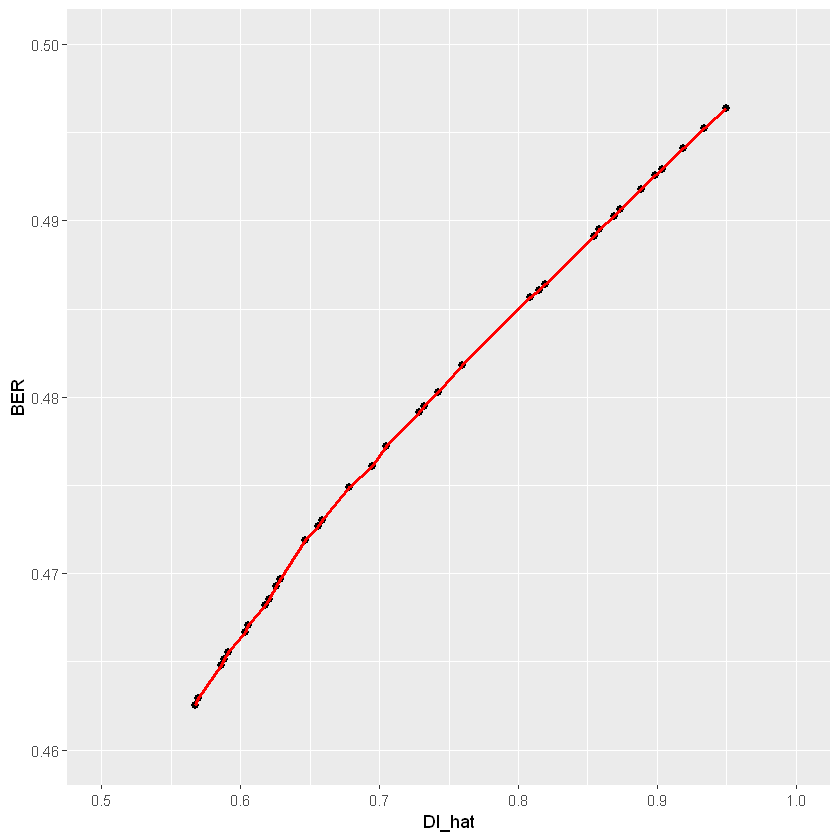

In [34]:
ggplot(DI.logit, aes(x=DI_hat, y=BER))+geom_point(size=2)+geom_line(color="red", lwd=1)+scale_x_continuous(limits=c(0.5,1))+scale_y_continuous(limits=c(0.46,0.5))

# p1<-ggplot(DI.logit, aes(x=lambda, y=DI_hat))+geom_point(size=2)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup),alpha=0.3, fill="blue")
# p1<-p1+scale_x_continuous(name ="Amount of repair", breaks=c(lambda_ev,1))+scale_y_continuous(name ="Disparate Impact", breaks=seq(0,1.5,by=0.1))+ggtitle("95% Confidence Interval for DI of Logistic Regression")
# p1+geom_hline(yintercept = c(0.8,1,DI_TR.logit[2]), lty=2)

In [35]:
lambda_ev<-lambda

In [36]:
p2<-ggplot(DI.logit, aes(x=lambda, y=error))+geom_point(size=2)+geom_line(color="green", lwd=1)+scale_x_continuous(name ="Amount of repair", breaks=c(lambda_ev,1))+scale_y_continuous(limits=c(0.192,0.208),breaks=c(0.192,0.196,0.200,0.204,0.208))

#p=1
#p3<-ggplot(DI.logit, aes(x=Wp_p_emp, y=DI_hat))+geom_point(size=2)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup),alpha=0.3, fill="blue")+scale_x_continuous(breaks=c(0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4))+scale_y_continuous(breaks=c(0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2))
#p=2
#p3<-ggplot(DI.logit, aes(x=Wp_p_emp, y=DI_hat))+geom_point(size=2)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup),alpha=0.3, fill="blue")+scale_x_continuous(limits=c(0,0.225), breaks=c(0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225))+scale_y_continuous(breaks=c(0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2))
#p=3
#p3<-ggplot(DI.logit, aes(x=Wp_p_emp, y=DI_hat))+geom_point(size=2)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup),alpha=0.3, fill="blue")+scale_x_continuous(breaks=c(0,0.025,0.05,0.075,0.10,0.125,0.15))+scale_y_continuous(breaks=c(0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2))

In [37]:
p3<-ggplot(FL, aes(x=Wp_p_emp, y=DI_hat,group=as.factor(p)))+geom_point(size=2)+geom_line(aes(color=as.factor(p)), lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup, fill=as.factor(p)),alpha=0.3)+scale_x_continuous()+scale_y_continuous(breaks=c(0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2))

#p=1
#p4<-ggplot(DI.logit, aes(x=lambda, y=Wp_p_emp))+geom_point(size=2)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=low,ymax=upp),alpha=0.3, fill="blue")
#p4<-p4+scale_x_continuous(name ="Amount of repair", breaks=c(lambda_ev,1))+scale_y_continuous(name ="Wasserstein distance")+ggtitle("95% Confidence Interval for Wp_p")
#p=2
#p4<-ggplot(DI.logit, aes(x=lambda, y=Wp_p_emp))+geom_point(size=2)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=low,ymax=upp),alpha=0.3, fill="blue")
#p4<-p4+scale_x_continuous(name ="Amount of repair", breaks=c(lambda_ev,1))+scale_y_continuous(name ="Wasserstein distance",breaks=c(0,0.05,0.1,0.15,0.2,0.25,0.3,0.35))+ggtitle("95% Confidence Interval for Wp_p")
#p=3

In [38]:
p4<-ggplot(FL, aes(x=lambda, y=Wp_p_emp,group=as.factor(p)))+geom_point(size=2)+geom_line(aes(color=as.factor(p)), lwd=1)+geom_ribbon(aes(ymin=low,ymax=upp, group=as.factor(p), fill=as.factor(p)),alpha=0.3)
p4<-p4+scale_x_continuous(name ="Amount of repair", breaks=c(lambda_ev,1))+scale_y_continuous(name ="Wasserstein distance")+ggtitle("95% Confidence Interval for Wp_p")

#p5<-ggplot(DI.logit, aes(x=lambda, y=BER))+geom_line(color="green")+scale_x_continuous(name ="Amount of repair", breaks=c(lambda_ev,1))
#p5+geom_hline(yintercept = 0.5, lty=2)

#p=2
#p6<-ggplot(DI.logit, aes(x=Wp_p_emp, y=BER))+geom_point(size=2)+geom_line(color="red", lwd=1)+scale_y_continuous(limits=c(0.46,0.5))+scale_x_continuous(limits=c(0,0.225), breaks=c(0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225))
#p=1
#p6<-ggplot(DI.logit, aes(x=Wp_p_emp, y=BER))+geom_point(size=2)+geom_line(color="red", lwd=1)+scale_y_continuous(limits=c(0.46,0.5))+scale_x_continuous(breaks=c(0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4))
#p=3
#p6<-ggplot(DI.logit, aes(x=Wp_p_emp, y=BER))+geom_point(size=2)+geom_line(color="red", lwd=1)+scale_y_continuous(limits=c(0.46,0.5))+scale_x_continuous(breaks=c(0,0.05,0.1,0.15,0.2,0.25,0.3))

In [39]:
p6<-ggplot(FL, aes(x=Wp_p_emp, y=BER,group=p))+geom_point(size=2)+geom_line(aes(color=as.factor(p)), lwd=1)+scale_y_continuous(limits=c(0.46,0.5))+scale_x_continuous()

In [40]:
#Wasserstein W_2(L(f(X)|S=0),L(f(X)|S=1)) vs BER
p7<-ggplot(DI.logit, aes(x=Wp_p_scale, y=BER))+geom_point(size=2)+geom_line(color="red", lwd=1)

In [41]:
#Wasserstein W_2(L(f(X)|S=0),L(f(X)|S=1)) vs DI
p8<-ggplot(DI.logit, aes(x=Wp_p_scale, y=DI_hat))+geom_point(size=2)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup),alpha=0.3, fill="blue")

In [42]:
#CI Wasserstein W_2(L(f(X)|S=0),L(f(X)|S=1)) with lambda
p9<-ggplot(DI.logit, aes(x=lambda, y=Wp_p_scale))+geom_point(size=2)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=low_scale,ymax=upp_scale),alpha=0.3, fill="blue")
p9<-p9+scale_x_continuous(name ="Amount of repair", breaks=c(lambda_ev,1))+scale_y_continuous(name ="Wasserstein distance")+ggtitle("95% Confidence Interval for Wp_p")

In [43]:
#perdida en la prediccion rf
tau<-disparate(coded_data,1,9)[2]
tauf<-DI_TR.rf[2]
lambda<-0
i<-1
DI.rf<-vector()
error_PRepair.rf<-vector()
lambda_ev<-lambda
#  tau<-tau0

In [44]:
#increase level of repair untill DI>=1
while(lambda<1){
  #if(sum(as.character(lambda_ev)=="1")==1) break

  x0_P_repair<-(1-lambda*pi1)*x0+lambda*pi1*(n0*t.opt$solution%*%as.matrix(x1))
  x1_P_repair<-lambda*pi0*(n1*t(t.opt$solution)%*%as.matrix(x0))+(1-lambda*pi0)*x1
  coded_data_P_repair<-rbind(x0_P_repair, x1_P_repair)
  coded_data_P_repair$PV<-c(rep(0,n0), rep(1,n1))
  #coded_data_P_repair$Y.logit<-1*(predict(logit, newdata = coded_data_P_repair, type="response")>0.5)
  coded_data_P_repair$Y.rf<-as.numeric(predict(rf.fit, coded_data_P_repair)$predictions)-1
  #DI_PR.logit<-disparate(coded_data_P_repair,6,7,0.05)
  DI_PR.rf<-disparate(coded_data_P_repair,6,7)
  
  #sort repaired data as in the original subsample data frame
  coded_data_P_repair<-coded_data_P_repair[rownames(coded_data),]
  
  #perdida en la prediccion rf
  conf_matrix_PRepair<-table(coded_data$income, coded_data_P_repair$Y.rf)
  error_PRepair.rf[i]<-(conf_matrix_PRepair[1,2]+conf_matrix_PRepair[2,1])/sum(conf_matrix_PRepair)
  DI.rf<-rbind(DI.rf,DI_PR.rf)
  
  tau<-DI_PR.rf[2]
  i<-i+1

  lambda_ev<-c(lambda_ev,lambda)
  lambda<-lambda+0.025
  #tau<-DI_PR.rf[2]
}

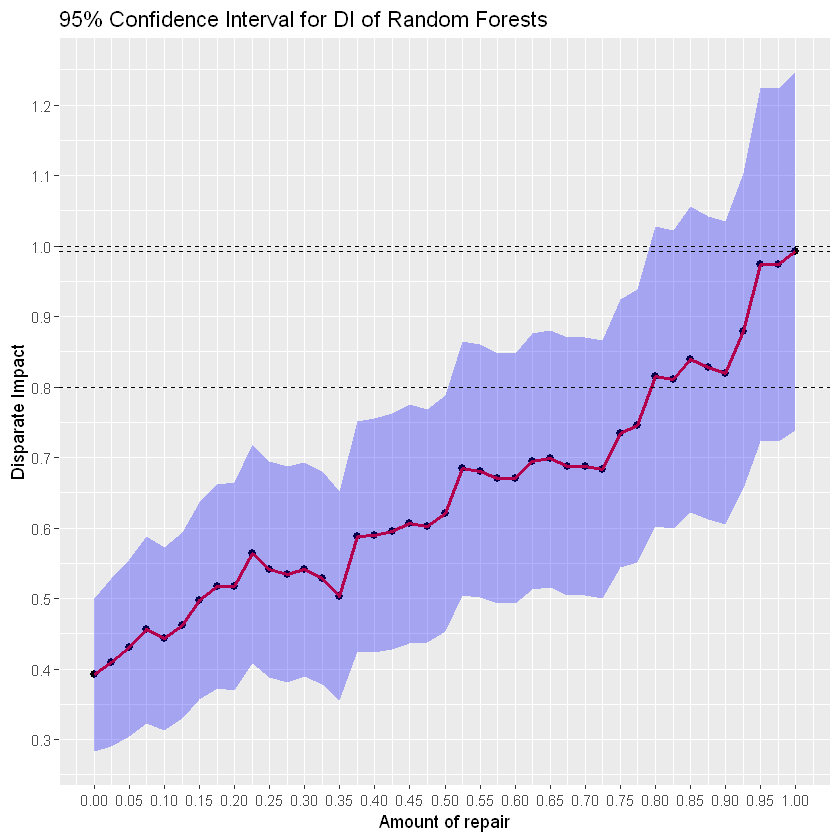

In [45]:
rownames(DI.rf)<-as.character(c(1:nrow(DI.rf)))
DI.rf<-as.data.frame(DI.rf)
names(DI.rf)<-c("linf","DI_hat","lsup")
DI.rf$lambda<-lambda_ev[-1]
DI.rf$error<-error_PRepair.rf[1:nrow(DI.rf)]
#añado con lambda=1
DI.rf<-rbind(DI.rf,c(DI_TR.rf,1,error_TRepair.rf))

p1<-ggplot(DI.rf, aes(x=lambda, y=DI_hat))+geom_point(size=2)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup),alpha=0.3, fill="blue")
p1<-p1+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=0.05))+scale_y_continuous(name ="Disparate Impact", breaks=seq(0,1.5,by=0.1))+ggtitle("95% Confidence Interval for DI of Random Forests")
p1+geom_hline(yintercept = c(0.8,1,DI_TR.rf[2]), lty=2)
p2<-ggplot(DI.rf, aes(x=lambda, y=error))+geom_line(color="green")+scale_x_continuous(name ="Amount of repair", breaks=lambda_ev)

In [46]:
##########Plotting together

DI.rf$rule<-"RF"
DI.logit$rule<-"logit"

In [47]:
#On renomme la colonne "NA" de DI.rf pour pouvoir faire rbind(DI.rf, DI.logit)
names(DI.rf) <- c("linf", "DI_hat", "lsup", "BER", "lambda", "error", "rule")

In [48]:
DI_PR<-rbind(DI.rf, DI.logit)

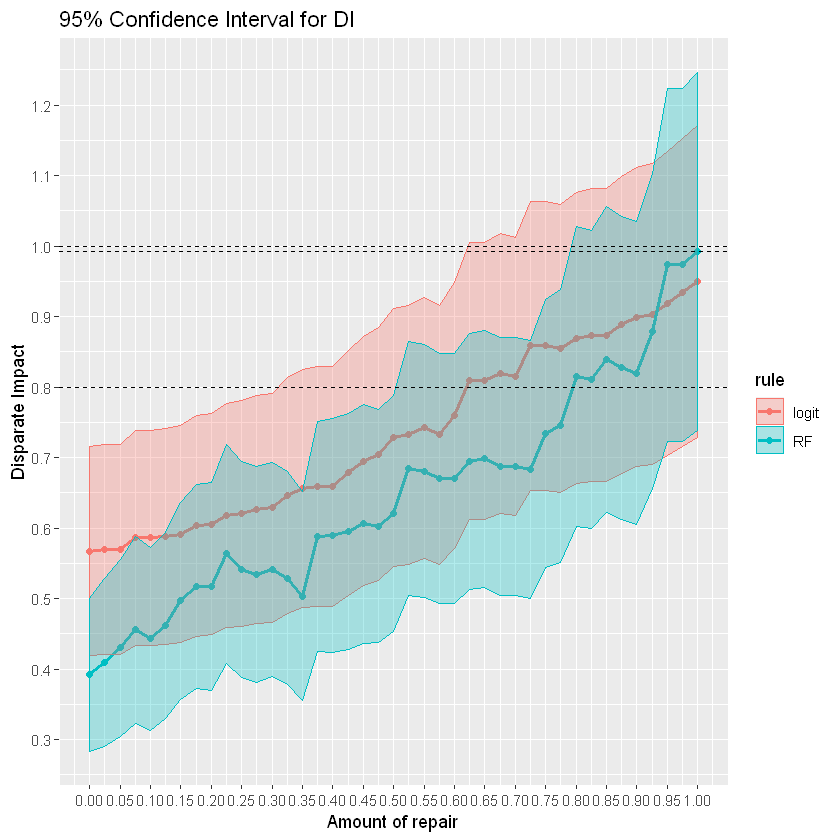

In [49]:
DI_PR$repair<-"PR"
p1<-ggplot(DI_PR, aes(x=lambda, y=DI_hat, color=rule))+geom_point(size=1.5)+geom_line(lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup, fill=rule),alpha=0.3)
p1<-p1+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=0.05))+scale_y_continuous(name ="Disparate Impact", breaks=seq(0,1.5,by=0.1))+ggtitle("95% Confidence Interval for DI")
p1+geom_hline(yintercept = c(0.8,1,DI_TR.rf[2]), lty=2)
p2<-ggplot(DI_PR, aes(x=lambda, y=error, color=rule))+geom_line()+scale_x_continuous(name ="Amount of repair", breaks=lambda_ev)

On a tracé les intervalles de confiances à 95% pour le Disparate Impact, obtenus avec les deux règles de classification "logit" et "Random Forests". 
La borne supérieure de l'intervalle de confiance du DI atteint 0.8 pour une quantité de réparation $\lambda$ d'environ .... pour la règle de classification logit.
La borne supérieure de l'intervalle de confiance du DI atteint 0.8 pour une quantité de réparation $\lambda$ d'environ .... pour la règle de classification RF.
Ainsi, la règle logit permet d'atteindre plus rapidement l'équitabilité.

In [52]:
###############################################

#4) RANDOM REPAIR FULL IMPREDICTABILITY

#####################################

install.packages("Rlab", repos= "https://cran.r-project.org")
library(Rlab)

Installing package into 'C:/Users/fanny/OneDrive/Documents/R/win-library/3.4'
(as 'lib' is unspecified)
Warning message:
"package 'Rlab' is in use and will not be installed"

In [53]:
#LOGIT

tau<-disparate(coded_data,1,8)[2]

#hacemos 100 repiticiones del experimento para presentar la media y que no sea tan brusco
DI_RR_L<-list()
for(k in 1:100){
lambda<-0
i<-1
DI_RR.logit<-vector()
error_RR.logit<-vector()
lambda_ev<-lambda
    
    #increase level of repair untill DI>=0.8
  while(lambda<1){
 
    B0<-rbern(n0,lambda)
    B1<-rbern(n1,lambda)
    # x0[B0==0,] and x1[B1==0,] are the instances that will not be repaired
    x0_repair<-pi0*x0[index_positive[index_positive[,1]%in%which(B0==1),1],]+pi1*x1[index_positive[index_positive[,1]%in%which(B0==1),2],]
   x0_repair$names<-as.character(id_x0[index_positive[index_positive[,1]%in%which(B0==1),1]])
    x1_repair<-pi0*x0[index_positive[index_positive[,2]%in%which(B1==1),1],]+pi1*x1[index_positive[index_positive[,2]%in%which(B1==1),2],]
    x1_repair$names<-as.character(id_x1[index_positive[index_positive[,2]%in%which(B1==1),2]])
    x0_no_repair<-x0[B0==0,]
    x0_no_repair$names<-as.character(id_x0[B0==0])
    x1_no_repair<-x1[B1==0,]
    x1_no_repair$names<-as.character(id_x1[B1==0])
    x_repair<-rbind(x0_no_repair,x0_repair,x1_no_repair,x1_repair)
    x_repair$PV<-c(rep(0,nrow(x0_no_repair) + nrow(x0_repair)), rep(1,nrow(x1_no_repair)+ nrow(x1_repair)))
    
  
    x_repair$Y.logit<-1*(predict(logit, newdata = x_repair, type="response")>0.5)
    #x_repair$Y.rf<-as.numeric(predict(rf.fit, x_repair)$predictions)-1
    
    #sort repaired data as in the original subsample data frame
    #coded_data_R_repair<-coded_data_R_repair[rownames(coded_data),]
    DI_RR<-disparate(x_repair,7,8)
   
    
    Y_ext<-coded_data[x_repair$names,]$income
    #perdida logit
    conf_matrix_RRepair<-table(Y_ext, x_repair$Y.logit)
    error_RR.logit[i]<-(conf_matrix_RRepair[1,2]+conf_matrix_RRepair[2,1])/sum(conf_matrix_RRepair)

    #perdida rf
    #conf_matrix_RRepair<-table(Y_ext, x_repair$Y.rf)
    #error_RRepair<-(conf_matrix_RRepair[1,2]+conf_matrix_RRepair[2,1])/sum(conf_matrix_RRepair)
    DI_RR.logit<-rbind(DI_RR.logit,DI_RR)
    tau<-DI_RR[2]
    i<-i+1
    
    lambda_ev<-c(lambda_ev,lambda)
    lambda<-lambda+0.005
  }

rownames(DI_RR.logit)<-as.character(c(1:nrow(DI_RR.logit)))
DI_RR.logit<-as.data.frame(DI_RR.logit)
names(DI_RR.logit)<-c("linf","DI_hat","lsup")
DI_RR.logit$lambda<-lambda_ev[-1]
DI_RR.logit$error<-error_RR.logit
#añado con lambda=1
DI_RR.logit<-rbind(DI_RR.logit, c(DI_FI.logit, 1, error_FIRepair.logit))
DI_RR_L[[k]]<-DI_RR.logit
}

In [54]:
LINF<-lapply(DI_RR_L, "[[", 1)[[1]]
DIHAT<-lapply(DI_RR_L, "[[", 2)[[1]]
LSUP<-lapply(DI_RR_L, "[[", 3)[[1]]
ERROR<-lapply(DI_RR_L, "[[", 5)[[1]]

In [55]:
for(i in 2:100){
  LINF<-cbind(LINF,lapply(DI_RR_L, "[[", 1)[[i]])
  DIHAT<-cbind(DIHAT,lapply(DI_RR_L, "[[", 2)[[i]])
  LSUP<-cbind(LSUP,lapply(DI_RR_L, "[[", 3)[[i]])
  ERROR<-cbind(ERROR,lapply(DI_RR_L, "[[", 5)[[i]])
}

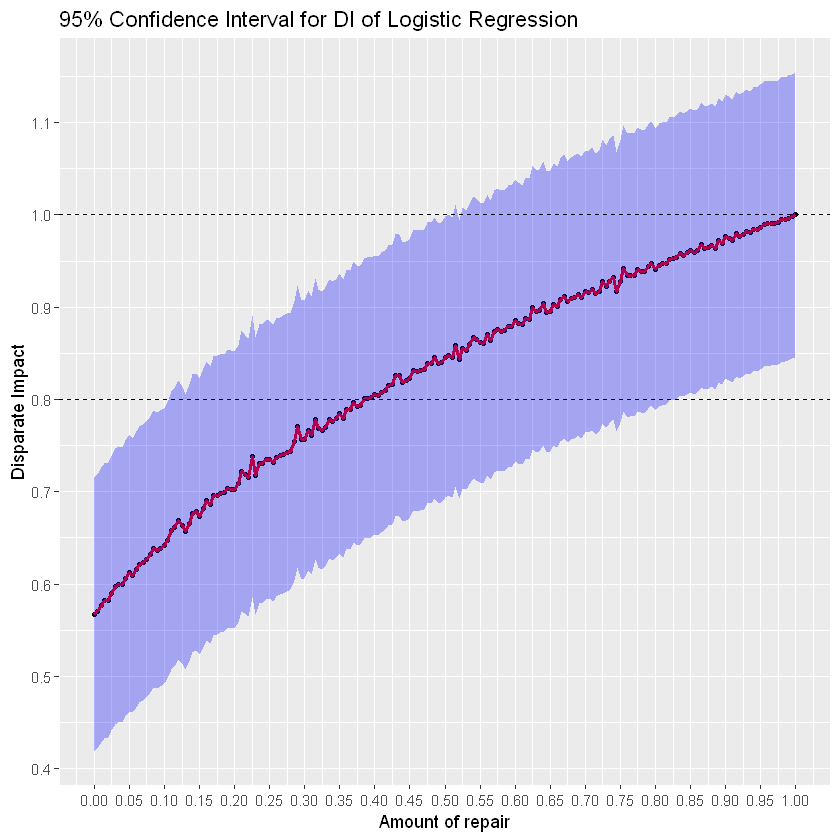

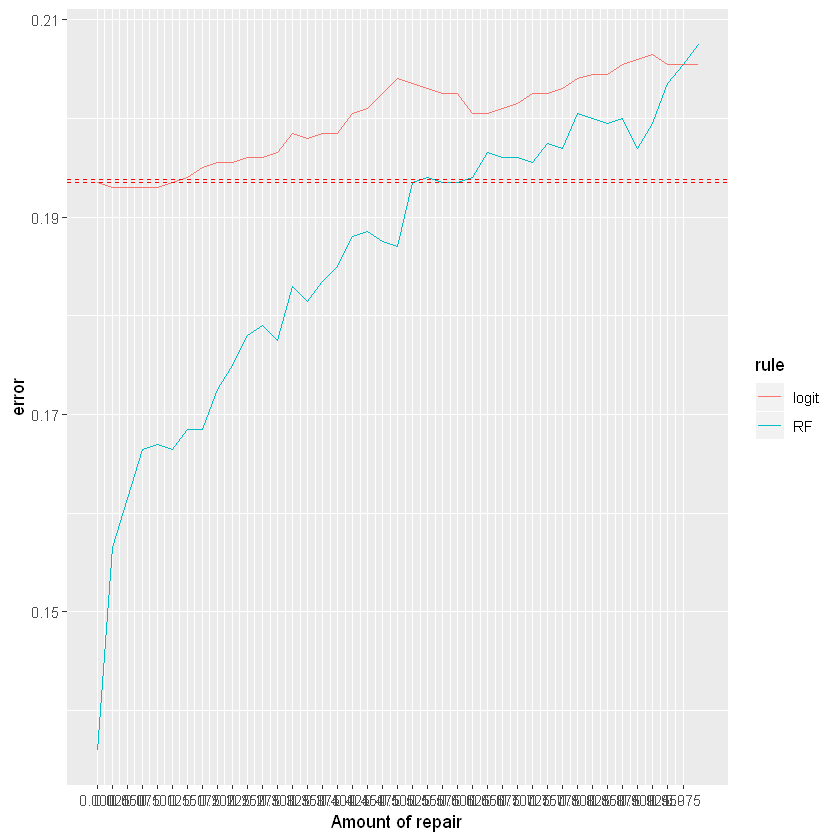

In [56]:
mLINF<-apply(LINF,MARGIN = 1, FUN = mean)
mDIHAT<-apply(DIHAT,MARGIN = 1, FUN = mean)
mLSUP<-apply(LSUP,MARGIN = 1, FUN = mean)
mERROR<-apply(ERROR,MARGIN = 1, FUN = mean)
mDI_RR.logit<-as.data.frame(cbind(mLINF,mDIHAT,mLSUP,mERROR,seq(0,1,by=0.005)))
names(mDI_RR.logit)[5]<-"lambda"

p1<-ggplot(mDI_RR.logit, aes(x=lambda, y=mDIHAT))+geom_point(size=1)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=mLINF,ymax=mLSUP),alpha=0.3, fill="blue")
p1<-p1+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=0.05))+scale_y_continuous(name ="Disparate Impact", breaks=seq(0,1.5,by=0.1))+ggtitle("95% Confidence Interval for DI of Logistic Regression")
p1+geom_hline(yintercept = c(0.8,1), lty=2)
#p2<-ggplot(mDI_RR.logit, aes(x=lambda, y=mERROR))+geom_line(color="green")+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=.05))+scale_y_continuous(name ="error", breaks=seq(0.1,0.3,by=.05))+ggtitle("Classification Error with Logistic Regression")
p2+geom_hline(yintercept = c(error_FIRepair.logit,error0.logit), lty=2, color=c("red"))

In [57]:
## NE JAMAIS REEXECUTER (1 HEURE)

##RANDOM FORESTS
tau<-disparate(coded_data,1,9)[2]

DI_RR_L2<-list()
for(k in 1:100){
lambda<-0
i<-1
DI_RR.rf<-vector()
error_RR.rf<-vector()
lambda_ev<-lambda

i<-1
#increase level of repair untill DI>=0.8
while(lambda<1){
  B0<-rbern(n0,lambda)
  B1<-rbern(n1,lambda)
  # x0[B0==0,] and x1[B1==0,] are the instances that will not be repaired
  x0_repair<-pi0*x0[index_positive[index_positive[,1]%in%which(B0==1),1],]+pi1*x1[index_positive[index_positive[,1]%in%which(B0==1),2],]
  x0_repair$names<-as.character(id_x0[index_positive[index_positive[,1]%in%which(B0==1),1]])
  x1_repair<-pi0*x0[index_positive[index_positive[,2]%in%which(B1==1),1],]+pi1*x1[index_positive[index_positive[,2]%in%which(B1==1),2],]
  x1_repair$names<-as.character(id_x1[index_positive[index_positive[,2]%in%which(B1==1),2]])
  x0_no_repair<-x0[B0==0,]
  x0_no_repair$names<-as.character(id_x0[B0==0])
  x1_no_repair<-x1[B1==0,]
  x1_no_repair$names<-as.character(id_x1[B1==0])
  x_repair<-rbind(x0_no_repair,x0_repair,x1_no_repair,x1_repair)
  x_repair$Sex<-c(rep(0,nrow(x0_no_repair) + nrow(x0_repair)), rep(1,nrow(x1_no_repair)+ nrow(x1_repair)))
  
  x_repair$Y.rf<-as.numeric(predict(rf.fit, x_repair)$predictions)-1
  
  #sort repaired data as in the original subsample data frame
  #coded_data_R_repair<-coded_data_R_repair[rownames(coded_data),]
  DI_RR<-disparate(x_repair,7,8,0.05)
  
  Y_ext<-coded_data[x_repair$names,]$income
  conf_matrix_RRepair<-table(Y_ext, x_repair$Y.rf)
  error_RR.rf[i]<-(conf_matrix_RRepair[1,2]+conf_matrix_RRepair[2,1])/sum(conf_matrix_RRepair)
  
  #perdida rf
  #conf_matrix_RRepair<-table(Y_ext, x_repair$Y.rf)
  #error_RRepair<-(conf_matrix_RRepair[1,2]+conf_matrix_RRepair[2,1])/sum(conf_matrix_RRepair)
  DI_RR.rf<-rbind(DI_RR.rf,DI_RR)
  
  i<-i+1
  
  lambda_ev<-c(lambda_ev,lambda)
  lambda<-lambda+0.005
}
    
rownames(DI_RR.rf)<-as.character(c(1:nrow(DI_RR.rf)))
DI_RR.rf<-as.data.frame(DI_RR.rf)
names(DI_RR.rf)<-c("linf","DI_hat","lsup")
DI_RR.rf$lambda<-lambda_ev[-1]
DI_RR.rf$error<-error_RR.rf
#añado con lambda=1
DI_RR.rf<-rbind(DI_RR.rf, c(DI_FI.rf, 1, error_FIRepair.rf))
DI_RR_L2[[k]]<-DI_RR.rf
}

In [58]:
LINF<-lapply(DI_RR_L2, "[[", 1)[[1]]
DIHAT<-lapply(DI_RR_L2, "[[", 2)[[1]]
LSUP<-lapply(DI_RR_L2, "[[", 3)[[1]]
ERROR<-lapply(DI_RR_L2, "[[", 5)[[1]]
for(i in 2:100){
  LINF<-cbind(LINF,lapply(DI_RR_L2, "[[", 1)[[i]])
  DIHAT<-cbind(DIHAT,lapply(DI_RR_L2, "[[", 2)[[i]])
  LSUP<-cbind(LSUP,lapply(DI_RR_L2, "[[", 3)[[i]])
  ERROR<-cbind(ERROR,lapply(DI_RR_L2, "[[", 5)[[i]])
}

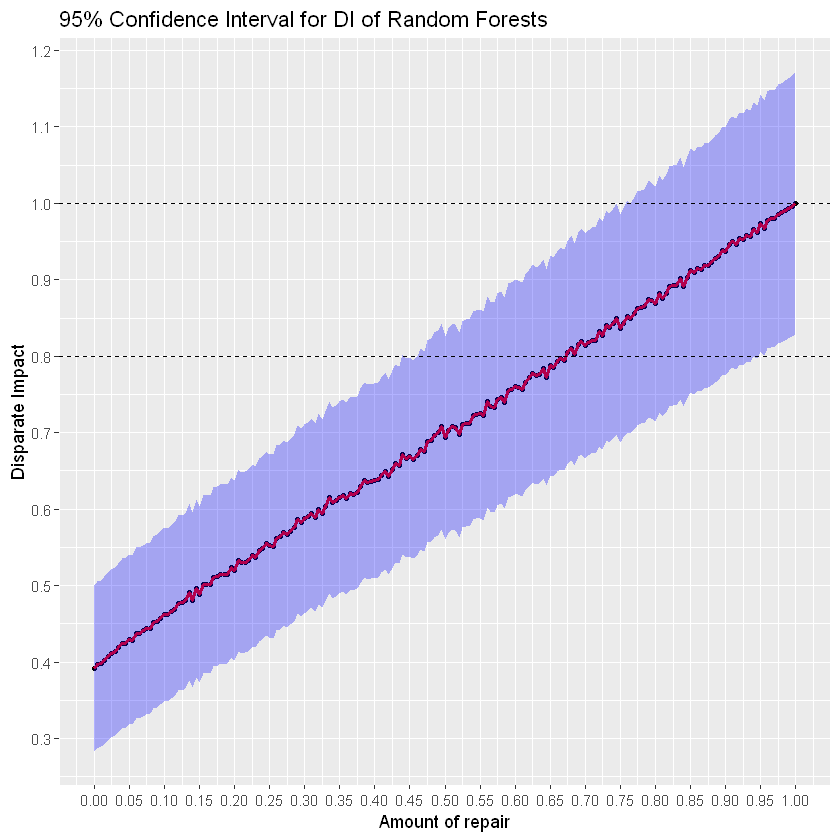

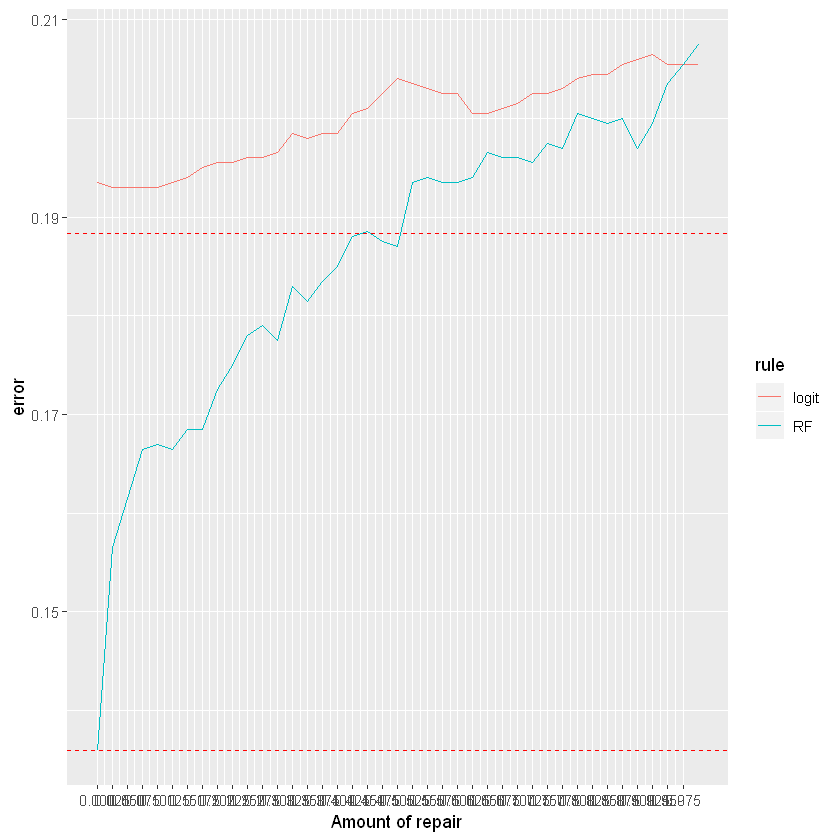

In [59]:
mLINF<-apply(LINF,MARGIN = 1, FUN = mean)
mDIHAT<-apply(DIHAT,MARGIN = 1, FUN = mean)
mLSUP<-apply(LSUP,MARGIN = 1, FUN = mean)
mERROR<-apply(ERROR,MARGIN = 1, FUN = mean)
mDI_RR.rf<-as.data.frame(cbind(mLINF,mDIHAT,mLSUP,mERROR,seq(0,1,by=0.005)))
names(mDI_RR.rf)[5]<-"lambda"

p1<-ggplot(mDI_RR.rf, aes(x=lambda, y=mDIHAT))+geom_point(size=1)+geom_line(color="red", lwd=1)+geom_ribbon(aes(ymin=mLINF,ymax=mLSUP),alpha=0.3, fill="blue")
p1<-p1+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=0.05))+scale_y_continuous(name ="Disparate Impact", breaks=seq(0,1.5,by=0.1))+ggtitle("95% Confidence Interval for DI of Random Forests")
p1+geom_hline(yintercept = c(0.8,1), lty=2)
#p2<-ggplot(mDI_RR.rf, aes(x=lambda, y=mERROR))+geom_line(color="green")+scale_x_continuous(name ="Amount of repair", breaks=lambda_ev)+scale_y_continuous(name ="error", breaks=seq(0,0.5,by=0.05))+ggtitle("Classification Error with Random Forests")
p2+geom_hline(yintercept = c(error_FIRepair.rf,error0.rf), lty=2, color=c("red"))

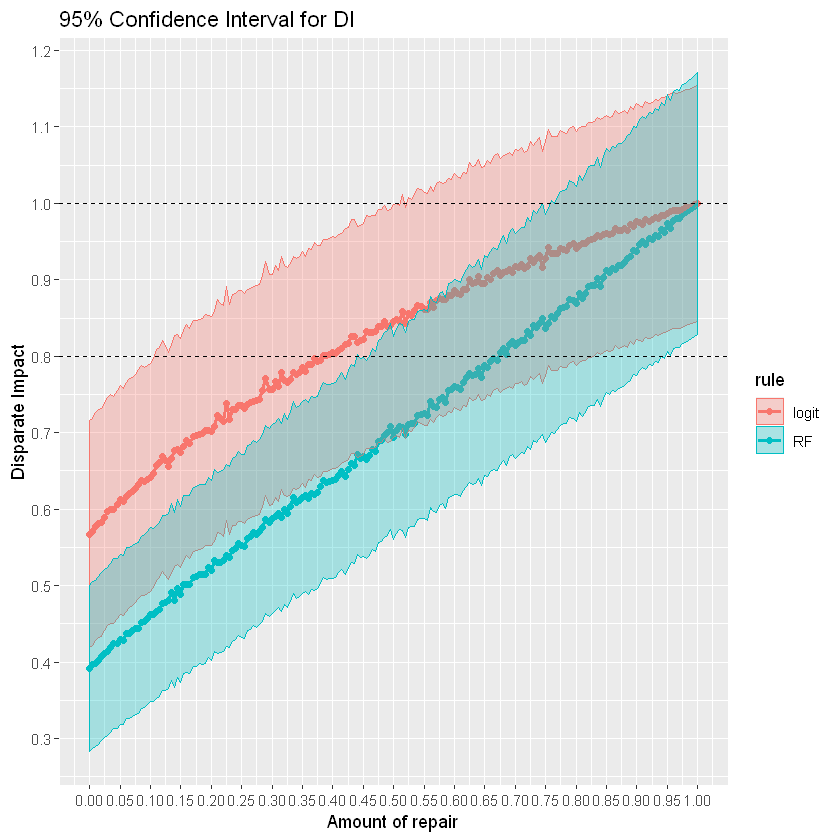

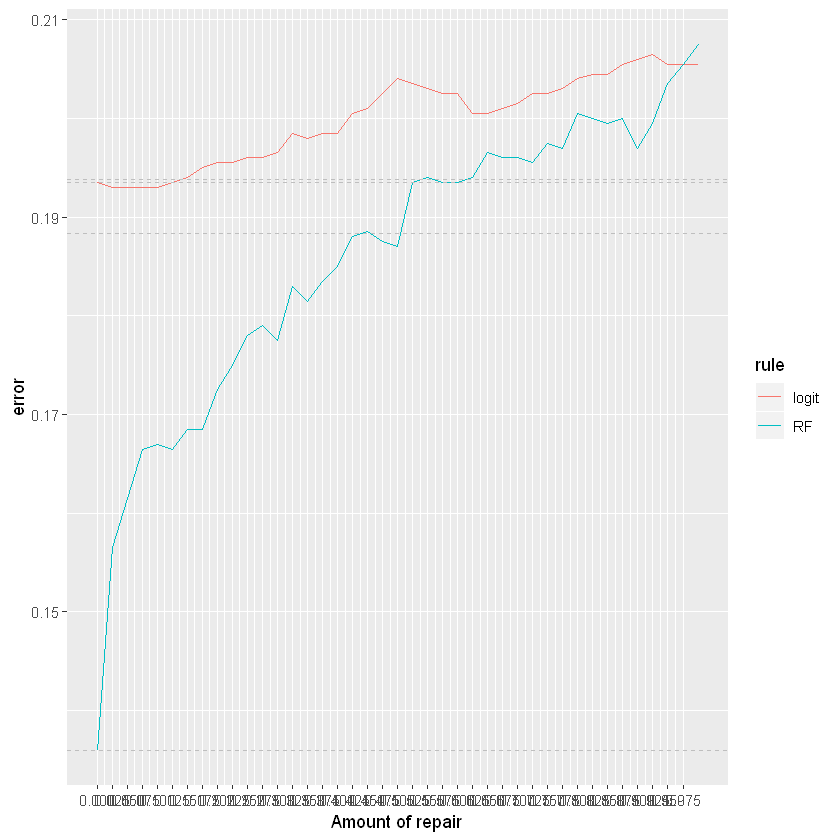

In [60]:
##########Plotting together

mDI_RR.rf$rule<-"RF"
mDI_RR.logit$rule<-"logit"
mDI_RR<-rbind(mDI_RR.rf, mDI_RR.logit)
mDI_RR$repair<-"RR"
names(mDI_RR)[1:4]<-c("linf", "DI_hat","lsup", "error")
p1<-ggplot(mDI_RR, aes(x=lambda, y=DI_hat, color=rule))+geom_point(size=1.5)+geom_line(lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup, fill=rule),alpha=0.3)
p1<-p1+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=0.05))+scale_y_continuous(name ="Disparate Impact", breaks=seq(0,1.5,by=0.1))+ggtitle("95% Confidence Interval for DI")
p1+geom_hline(yintercept = c(0.8,1), lty=2)
#p2<-ggplot(mDI_RR, aes(x=lambda, y=error, color=rule))+geom_line()+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=0.05))+scale_y_continuous(name ="error")+ggtitle("Classification Error")
p2+geom_hline(yintercept = c(error_FIRepair.logit,error0.logit,error_FIRepair.rf,error0.rf), lty=2, color=c("grey"))

In [61]:
DI_PR <- DI_PR[, c(1:3,5:8)]

In [62]:
#######http://localhost:8888/notebooks/Adult-R-FairDataAnalysis.ipynb#########################################
mDI_RR<-mDI_RR[,c(1,2,3,5,4,6,7)]
DI_comp<-rbind(DI_PR, mDI_RR)
DI_comp$proc<-paste(DI_comp$rule,DI_comp$repair)

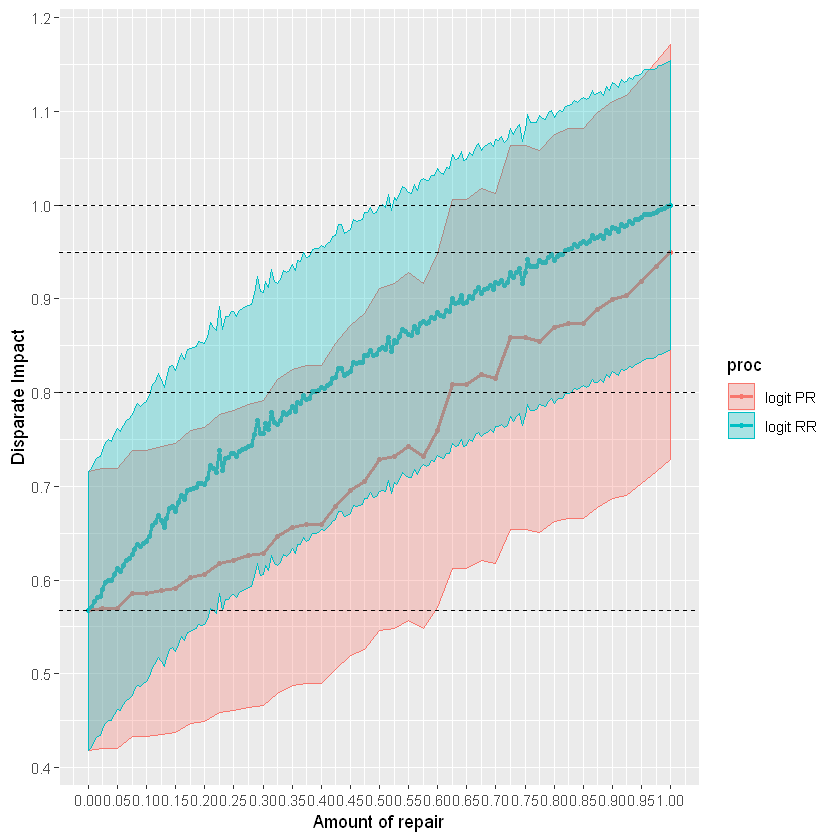

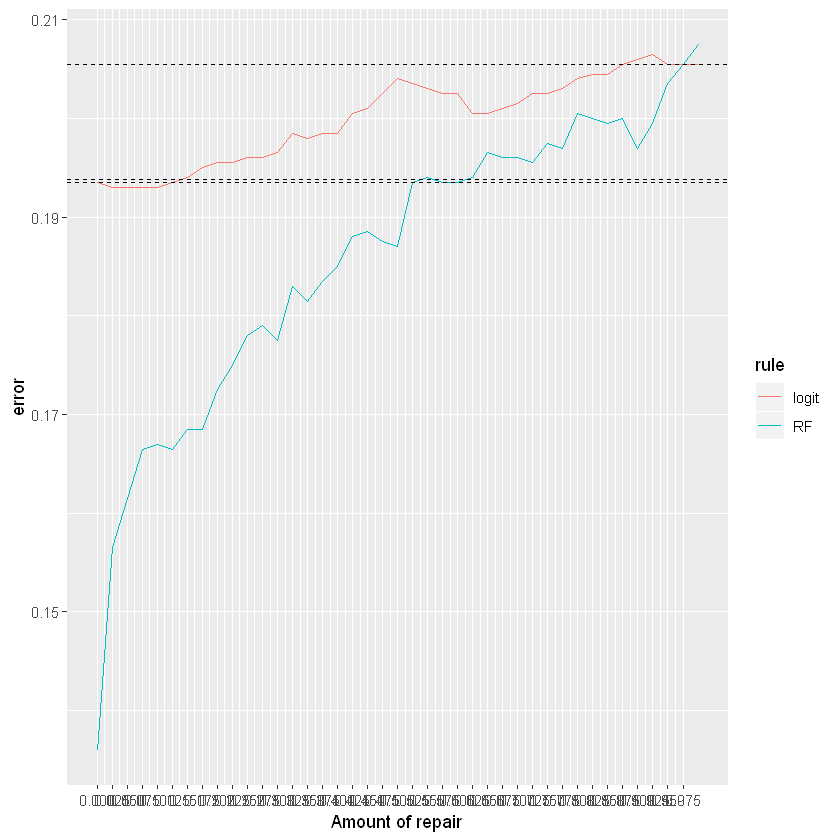

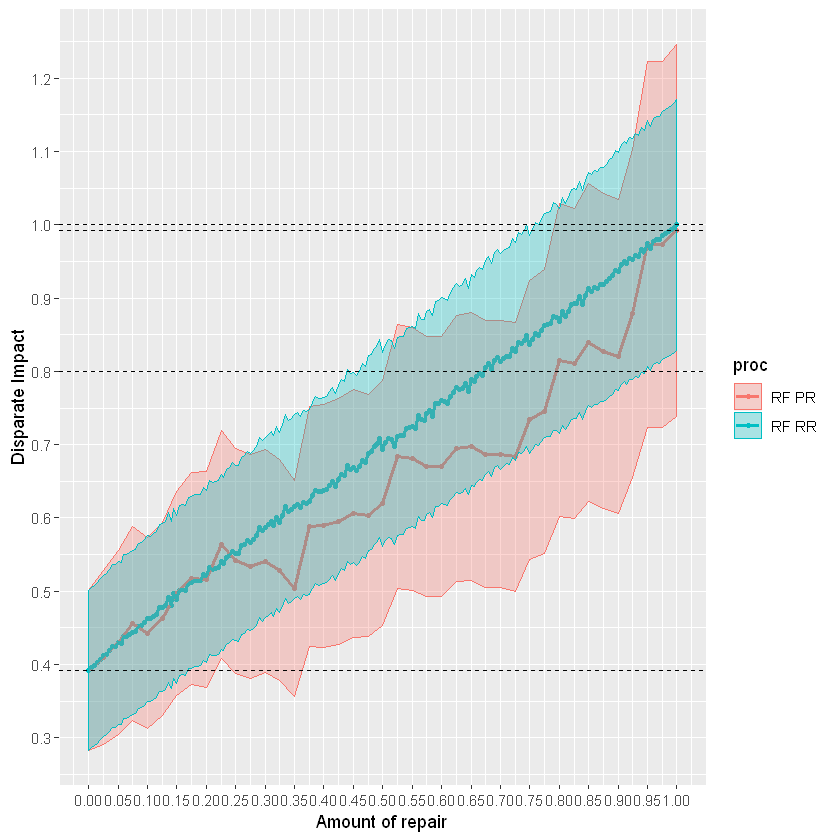

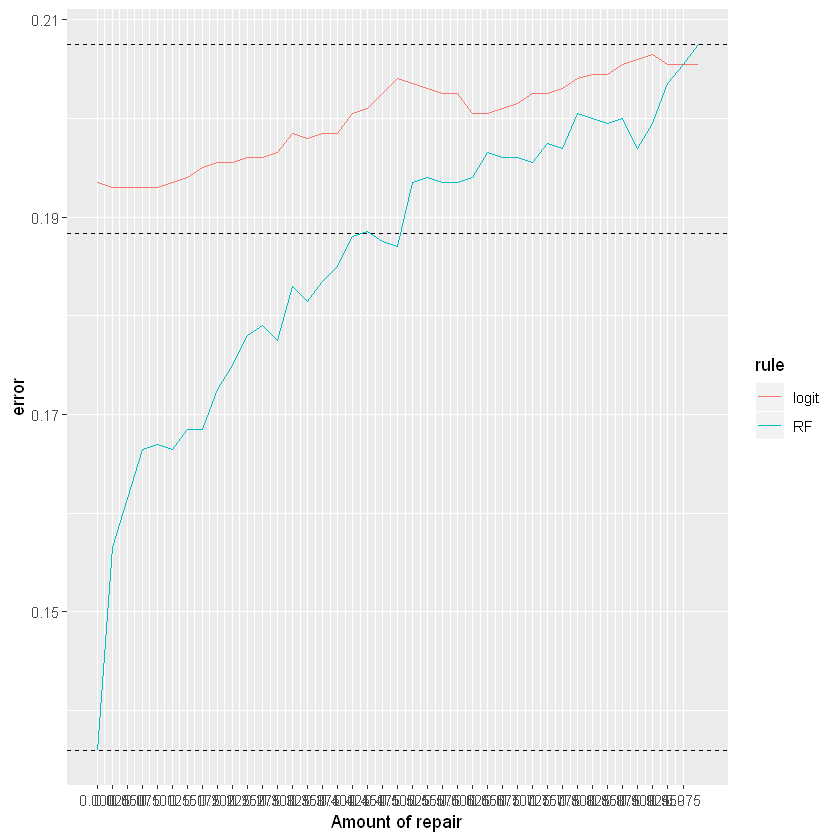

In [63]:
#logit
p1<-ggplot(DI_comp[DI_comp$rule=="logit",], aes(x=lambda, y=DI_hat, color=proc))+geom_point(size=1)+geom_line(lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup, fill=proc),alpha=0.3)
p1<-p1+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=0.05))+scale_y_continuous(name ="Disparate Impact", breaks=seq(0,1.5,by=0.1))
#+ggtitle("95% Confidence Interval for DI")
p1+geom_hline(yintercept = c(0.8,1,DI0.logit[2],DI_TR.logit[2]), lty=2)
#p2<-ggplot(DI_comp[DI_comp$rule=="logit",], aes(x=lambda, y=error, color=proc))+geom_line()+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=0.05))+scale_y_continuous(name ="error")
#+ggtitle("Classification Error")
p2+geom_hline(yintercept = c(error_FIRepair.logit,error_TRepair.logit,error0.logit), lty=2)
#rf
p1<-ggplot(DI_comp[DI_comp$rule=="RF",], aes(x=lambda, y=DI_hat, color=proc))+geom_point(size=1)+geom_line(lwd=1)+geom_ribbon(aes(ymin=linf,ymax=lsup, fill=proc),alpha=0.3)
p1<-p1+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=0.05))+scale_y_continuous(name ="Disparate Impact", breaks=seq(0,1.5,by=0.1))
#+ggtitle("95% Confidence Interval for DI")
p1+geom_hline(yintercept = c(0.8,1,DI0.rf[2],DI_TR.rf[2]), lty=2)
#p2<-ggplot(DI_comp[DI_comp$rule=="RF",], aes(x=lambda, y=error, color=proc))+geom_line()+scale_x_continuous(name ="Amount of repair", breaks=seq(0,1,by=0.05))+scale_y_continuous(name ="error")
#+ggtitle("Classification Error")
p2+geom_hline(yintercept = c(error_FIRepair.rf,error_TRepair.rf,error0.rf), lty=2)

##########